This is implementation of autoender architecture 

Load libs

In [1]:
from sklearn.model_selection import train_test_split
from file_utils import get_file_names_from_folder
from image_utils import load_images
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Conv2DTranspose
from tensorflow.keras import Model
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
plt.rcParams['figure.figsize'] = [15, 6]

2023-03-27 21:58:10.582273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load data

In [2]:
file_names = get_file_names_from_folder('data/SIDD_Small/')
gt_images = []
noisy_images = []
for image_path in file_names:
    if image_path.split('/')[-1].startswith('GT'):
        gt_images.append(image_path)
    else:
        noisy_images.append(image_path)

gt_images_set = load_images(gt_images)
noisy_images_set = load_images(noisy_images)


In [3]:
gt_images_set[0].shape

(128, 128, 3)

Split images to train and test sets

In [4]:
gt_train, gt_test, noisy_train, noisy_test = train_test_split(gt_images_set, noisy_images_set, test_size=0.20, random_state=42)
print(gt_train[0].shape)
print(len(gt_test))
print(len(noisy_train))
print(type(noisy_test))

(128, 128, 3)
32
128
<class 'numpy.ndarray'>


Plot some examples from datasets

(128, 128, 3)


(Text(0.5, 1.0, 'Noise image'), (-0.5, 127.5, 127.5, -0.5))

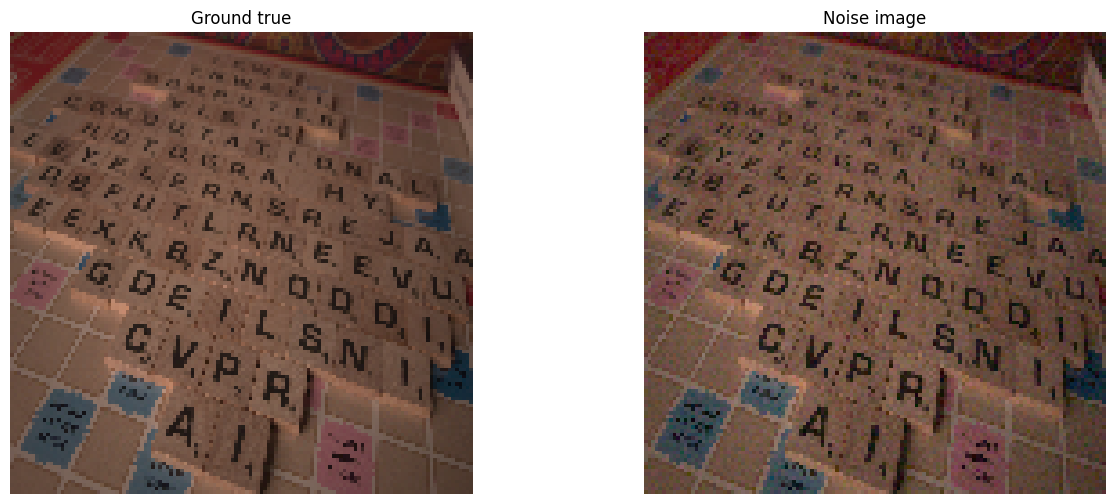

In [5]:
index = np.random.randint(0, len(gt_train))
print(gt_train[index].shape)
plt.subplot(1, 2, 1), plt.imshow(gt_train[index])
plt.title('Ground true'), plt.axis(False)
plt.subplot(1, 2, 2), plt.imshow(noisy_train[index])
plt.title('Noise image'), plt.axis(False)

lets calculate PSNR and SSID metrics for ground true and noisy images. This is our key metriccs that we try to increase

In [6]:
def calculate_key_metrics(gt_images, current_images):
    PSNR = 0
    SSID = 0
    for gt_image, noise_image in zip(gt_images, current_images):
        PSNR += psnr(gt_image, noise_image)
        SSID += ssim(gt_image, noise_image, channel_axis=2, data_range=noise_image.max() - noise_image.min())

    PSNR/=gt_images.shape[0]
    SSID/=current_images.shape[0]
    print("Original average PSNR ->", PSNR)
    print("Original average SSIM ->", SSID)
    
calculate_key_metrics(gt_images_set, noisy_images_set)

Original average PSNR -> 29.36045544284019
Original average SSIM -> 0.7196665462114444


apply data generation technics for increasing training set

In [7]:
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE=8
augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
image_generator_train = tf_data_generator(X=noisy_train, y=gt_train, batch_size=BATCH_SIZE, augmentations=augmentation_lst)
image_generator_test = tf_data_generator(X=noisy_test, y=gt_test, batch_size=BATCH_SIZE)
image_generator_train

2023-03-27 22:00:23.603250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<PrefetchDataset element_spec=(TensorSpec(shape=(8, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(8, 128, 128, 3), dtype=tf.float64, name=None))>

Build simple model

In [23]:
input = Input(shape=(128,128,3))

#encoder
net = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(input)
net = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(net)
net = MaxPooling2D((2, 2), padding="same")(net)
net = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(net)
net = MaxPooling2D((2, 2), padding="same")(net)
net = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding="same")(net)
net = MaxPooling2D((2, 2), padding="same")(net)

#decoder
net = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(net)
net = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(net)
net = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(net)
net = Conv2D(3, kernel_size=(1,1), activation="sigmoid", padding="same")(net)

autoencoder = Model(input, net)
autoencoder.compile(optimizer="adam", loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                       

In [10]:
print(noisy_train.shape, gt_train.shape)
print(noisy_test.shape, gt_test.shape)

(128, 128, 128, 3) (128, 128, 128, 3)
(32, 128, 128, 3) (32, 128, 128, 3)


In [11]:
steps_per_epoch_train = len(noisy_train)
steps_per_epoch_validation = len(noisy_test)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1,patience=2)
history = autoencoder.fit(
    image_generator_train,
    steps_per_epoch=steps_per_epoch_train,
    validation_steps=steps_per_epoch_validation,
    epochs=5,
    batch_size=8,
    shuffle=True,
    verbose=1,
    callbacks=[reducelr],
    validation_data=image_generator_test,
)

Epoch 1/5
128/128 [==============================] - 78s 598ms/step - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - lr: 0.0010
Epoch 2/5
128/128 [==============================] - 97s 756ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - lr: 0.0010
Epoch 3/5
128/128 [==============================] - 77s 604ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - lr: 0.0010
Epoch 4/5
128/128 [==============================] - 83s 649ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - lr: 0.0010
Epoch 5/5
128/128 [==============================] - 84s 659ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - lr: 0.0010


KeyError: 'accuracy'

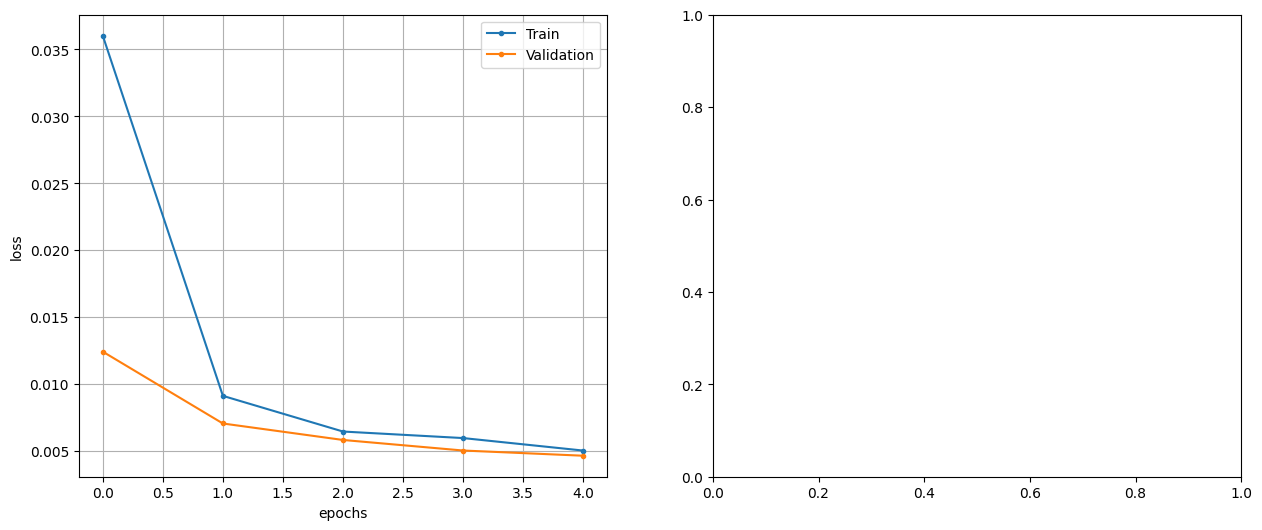

In [13]:
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])

In [17]:
predictions = autoencoder.predict(noisy_train[:2:])

1/1 [==============================] - 0s 266ms/step


In [22]:
print(type(predictions), type(gt_test))
calculate_key_metrics(noisy_train[:2:], predictions)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Original average PSNR -> 24.54936159618422
Original average SSIM -> 0.21011603518404404


/var/folders/zr/m75tnm4s4p1cj7v9pr8mtrdr0000gn/T/ipykernel_23169/4200771665.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  PSNR += psnr(gt_image, noise_image)


(Text(0.5, 1.0, 'Ground true'), (-0.5, 127.5, 127.5, -0.5))

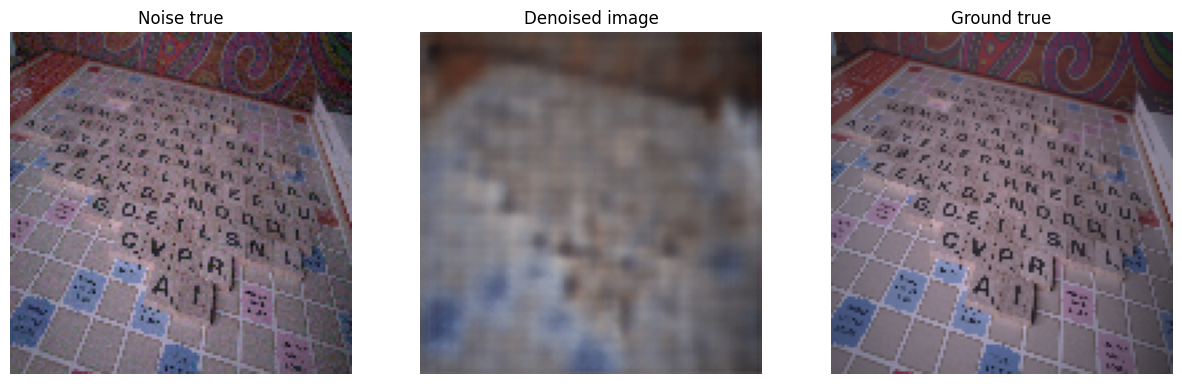

In [21]:
plt.subplot(1, 3, 1), plt.imshow(noisy_train[1])
plt.title('Noise true'), plt.axis(False)
plt.subplot(1, 3, 2), plt.imshow(predictions[1])
plt.title('Denoised image'), plt.axis(False)
plt.subplot(1, 3, 3), plt.imshow(gt_train[1])
plt.title('Ground true'), plt.axis(False)